In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
data = pd.read_excel("default of credit card clients.xls", header = 1)
pd.set_option('display.max_columns',100)
data.rename({"default payment next month":"default"},axis = 1, inplace = True)
data.drop("ID", axis=1, inplace =True)
data.head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0     -2     -2       3913       3102        689          0          0   
1      0      2       2682       1725       2682       3272       3455   
2      0      0      29239      14027      13559      14331      14948   
3      0      0      46990      48233      49291      28314      28959   
4      0      0       8617       5670      35835      20940      19146   

   BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0          0         0       689         0         0         0         0   
1       3261         0      1000      1000      1000         0      2000   
2      15549      1518      1500      1000      1000      1000      5000   
3      29547      2000      2019      1200      1100      1069      1000   
4      19131      2000     36681     10000      9000       689       679   

   default  
0        1  
1        1  
2        0  
3        0  
4        0

In [3]:
print("Null values")
data.isnull().sum()

Null values


LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

Class split
0    23364
1     6636
Name: default, dtype: int64


Text(0, 0.5, 'Count')

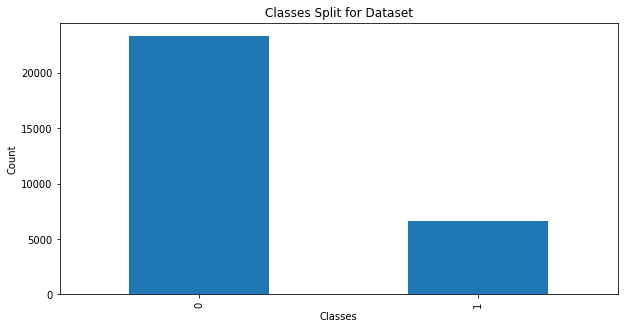

In [4]:
print('Class split')
print(data['default'].value_counts())
data['default'].value_counts().plot.bar(figsize=(10,5),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [5]:
lim_bal = data['LIMIT_BAL'].groupby(by=data['EDUCATION'].replace({1:"Graduate School",2:"University", 3:"Highschool", 4:"Others"})).mean()
limit_data=pd.DataFrame(lim_bal).reset_index()
#limit_data.rename(columns={'SEX':"Gender", "LIMIT_BAL":"Credit Limit"},inplace=True)
print(limit_data)
#sns.barplot(x='Gender',y="Credit Limit",data=limit_data)

         EDUCATION      LIMIT_BAL
0                0  217142.857143
1                5  168164.285714
2                6  148235.294118
3  Graduate School  212956.069910
4       Highschool  126550.270490
5           Others  220894.308943
6       University  147062.437634


In [6]:
new_data = data.copy()
new_data=new_data.drop(new_data[new_data['EDUCATION'] == 0].index)
new_data=new_data.drop(new_data[new_data['EDUCATION'] == 5].index)
new_data=new_data.drop(new_data[new_data['EDUCATION'] == 6].index)
print(new_data.shape)

(29655, 24)


In [7]:
x = new_data.drop('default',axis=1).to_numpy()
y = new_data['default'].to_numpy()

# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test_final = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)


In [8]:
#SMOTE oversampling
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_final = smt.fit_resample(x_train,y_train)

#Class Balance - Test Data
print('SMOTE - Class Split')
num_zeros = (y_train_final == 0).sum()
num_ones = (y_train_final == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

#Scale the Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_final = scaler.fit_transform(x_train_smt)
x_test_final = scaler.transform(x_test)

SMOTE - Class Split
Class 0 - 18436
Class 1 - 18436


In [9]:
from time import time

time_start=time()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rfc_model = RandomForestClassifier(random_state = 7, class_weight='balanced', n_jobs=-1)
params={"n_estimators":[150,200],
        "max_features": [6,7],
        'max_depth': [8,9],
       "criterion":['entropy']}
rfc_classifier = GridSearchCV(estimator = rfc_model, param_grid = params, scoring = "recall_weighted")
rfc_classifier.fit(x_train_final, y_train_final)
rfc_predict = rfc_classifier.predict(x_test_final)
print(rfc_classifier.best_params_)
print(classification_report(y_test_final, rfc_predict))

time_end=time()
print("Runtime  = ",time_end-time_start)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 6, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4609
           1       0.49      0.56      0.52      1322

    accuracy                           0.77      5931
   macro avg       0.68      0.70      0.69      5931
weighted avg       0.78      0.77      0.78      5931

Runtime  =  59.492775440216064


In [10]:
print('Feature Importances:')
for name, score in zip(list(new_data),rfc_classifier.best_estimator_.feature_importances_):
    print(name, round(score,2))

Feature Importances:
LIMIT_BAL 0.03
SEX 0.06
EDUCATION 0.03
MARRIAGE 0.07
AGE 0.02
PAY_0 0.17
PAY_2 0.17
PAY_3 0.07
PAY_4 0.04
PAY_5 0.04
PAY_6 0.02
BILL_AMT1 0.04
BILL_AMT2 0.02
BILL_AMT3 0.02
BILL_AMT4 0.02
BILL_AMT5 0.01
BILL_AMT6 0.01
PAY_AMT1 0.05
PAY_AMT2 0.03
PAY_AMT3 0.03
PAY_AMT4 0.02
PAY_AMT5 0.02
PAY_AMT6 0.02


In [11]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_final, 
                                                            y=y_train_final,
                                                            train_sizes= np.linspace(0.7, 1.0, 6),
                                                            cv=5,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

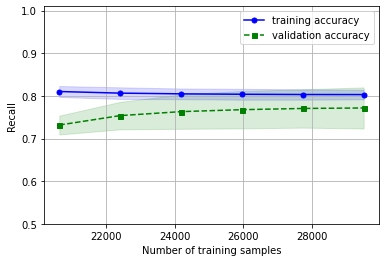

In [12]:
plot_learning_curves(rfc_classifier.best_estimator_)

ROC Curve


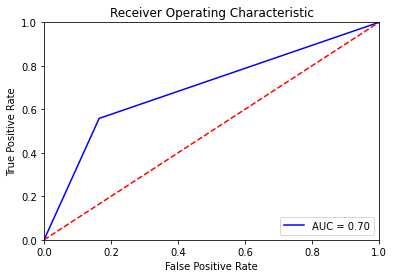

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
roc_auc = metrics.auc(fpr, tpr)
print('ROC Curve')
#Plot the ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

In [15]:
from sklearn import preprocessing
Forecast1=pd.DataFrame(rfc_predict)
Outcome1=pd.DataFrame(y_test_final)
lb1 = preprocessing.LabelBinarizer()
OutcomeB1 =lb1.fit_transform(Outcome1)
ForecastB1 = lb1.fit_transform(Forecast1)